In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
import zipfile
import os

# Path to the zip file on the google drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/lfw.zip'

# Path for unzipped file
extracted_path = './lfw/'

# Making directory for extraction
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [4]:
path = '/content/lfw/lfw'

In [16]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


torch.Size([250, 250, 3])


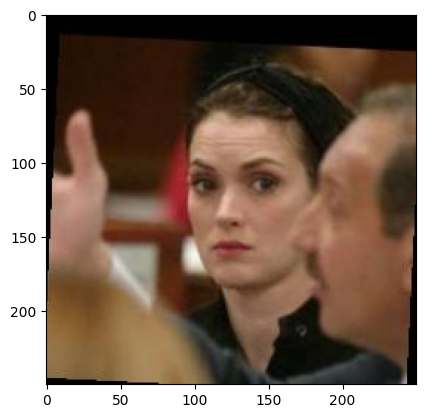

In [18]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.


**Architecture Difference**

**AutoEncoders** has two components Encoder and Decoder, the encoder consists of a series of neural network layers which extract features from an image and embed or encode them to a low-dimensional latent space.The decoder consists of a series of neural network layers which attempt to recreate the original image from the low-dimensional latent space. The architecture of the decoder is generally diverging.

AutoEncoders compress high-dimensional input data into a more comprehensible representation by using neural networks. From this reduced representation, the autoencoder then tries to reconstruct the input using fully connected or convolutional layers.
Autoencoders are usally deterministic models

**Variational autoencoders** map your input onto a distribution; you then feed a sample from that distribution to your decoder network, rather than converting it into a fixed vector.

With VAEs, the input data is still mapped by the encoder to a lower-dimensional latent space; however, the encoder produces a probability distribution over the latent space as opposed to a single point. In order to produce a new data point, the decoder then takes samples from this distribution. VAEs can learn a more continuous and organized latent space representation with this probabilistic approach to input encoding, which is helpful for generative modeling.


**Applicaitons**

**AutoEncoders :**

    1.Image and Audio compression

    2.Dimensionality reduction

    3.Denoising

**VAE's :**

    1.Data augmentation

    2.Generative Models

    3.Data Imputation


**Loss funciton**

**AutoEncoders** minimizing the difference between the input data and the reconstructed output is the goal of autoencoder training. This difference is usually quantified using a loss function like mean squared error.

**VAE** The difference between the original input and the output produced by the decoder is measured by the reconstruction loss. The difference between the learnt probability distribution and the predefined prior distribution is measured by the KL divergence loss.



# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [19]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(True)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(True)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU(True)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.ReLU(True)

        self.flatten = nn.Flatten()

        self.fc_mean = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_log_var = nn.Linear(128 * 16 * 16, latent_dim)

    def forward(self, x):
       
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
 

        x = self.flatten(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        # print(log_var.shape)


        return mean, log_var

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Input layer for sampled z
        self.fc_input = nn.Linear(latent_dim, 128*16*16,bias = True)

        self.reshape = lambda x: x.view(-1, *(128,16,16))

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,output_padding=1)
        self.relu1 = nn.ReLU(True)

        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(True)

        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU(True)

        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size= 3, stride=2, padding=1,output_padding=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, z):
        # print(z.shape,"The shaspe of z beofre sebfiong to decode")
        x = self.fc_input(z)
        # print(x.shape,"After one decode")
        x = self.reshape(x)
        # print("The shape is ",x.shape)

        x = self.relu1(self.deconv1(x))
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x_hat = self.sigmoid(self.deconv4(x))

        # print("the shape of o/p ", x_hat.shape)

        return x_hat


In [49]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = Decoder()

    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(mean)
        z = mean + torch.exp(0.5 * log_var) * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        # print("The enocder has two ouptuts Mean and Variance and the shape is", mean.shape)
        z = self.reparameterization(mean, log_var)
        # print("The shape of the vector which is feeding to decoder:", z.shape)
        x_hat = self.decoder(z)
        # print("The shape of the image from decoder is:",x_hat.shape)
        return x_hat, mean, log_var


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.


Answer:


It is well known that when translating input data to latent state, traditional autoencoders provide a single value for each dimension. Rather than doing this, VAEs produce a Gaussian probability distribution for each dimension, complete with a mean and standard deviation. If the latent state space has seven dimensions, for instance, you would obtain seven probability distributions that collectively reflect the state as a probability distribution over space.

Assuming that each member in the new vector is a random variable, this implies that we can effectively combine the two vectors into one(Mean and Variance).

Once we are aware of the encoding of our input, we may choose a random integer at random from the distribution used to create the encoding by sampling from all the variables. The decoder then receives this number and decodes it into, hopefully, interpretable output.


Summary :

The encoder network maps the input data to the latent space, represented by the mean and log-variance of a normal distribution. The sampling step generates new points in the latent space by sampling from this normal distribution using these parameters.

Mean and Variance are used as the parameters of the normal distribution from which the latent variables are sampled. In the decoder network, z is used as the input and is then mapped back to the original data space.


In [57]:
latent_dim = 128
random_image = torch.randn((1, 3, 250, 250))

model = VAE()

In [59]:
output = model(random_image)

The enocder has two ouptuts Mean and Variance and the shape is torch.Size([1, 128])
The shape of the vector which is feeding to decoder: torch.Size([1, 128])
The shape of the image from decoder is: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


Answer

The loss function for a VAE is typically composed of two parts: the **reconstruction loss** (similar to the traditional autoencoder loss) and the **KL divergence loss**.


**KL divergence loss**
The encoder produces the parameters of a probability distribution, such as mean and variance, rather than a point in the latent space.This distribution is typically a multivariate Gaussian distribution.

Term calculates the difference between a predetermined prior distribution (often a standard Gaussian distribution) and the learnt probability distribution across the latent space. In order to assist regularize the model and guarantee that the latent space has a meaningful structure, the KL divergence term makes sure that the learned distribution over the latent space is close to the prior distribution.

**Reconstruction loss**
The reconstruction loss measures the difference between the original input and the output generated by the decoder. Which is very much similar to traditional autoencoders.

In [61]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")

Total Trainable Parameters: 12810691


In [23]:
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [67]:
model = VAE().to(device)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?


**Answer**

 * If your loss is not decreasing steps - Recheck the below things:
 * Extremely high error rates can result from an excessive learning rate that either puts you out of reach of any local minima or traps you in an optimization cycle.
 * I might increase number of kernels in convolutional layers and reducing the batch size
 * Latent Space dimension increase / Decrease
 * Changing the optimizer from Adam to SGD
 * Modifying the batch size(increasing and decreasing)

In [24]:

import torchvision.transforms.functional as Fa

num_epochs = 20

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training loop
    for inputs, _ in dataloader:
        inputs = inputs.to(device)  # Move data to GPU
        optim.zero_grad()  # Zero the gradients
        outputs, mu_f, logvar_f = model(inputs)  # Forward pass


        kl = -0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
        kl_loss = kl.sum() / inputs.size(0)
        fit = 0.5 * (outputs - inputs).pow(2)
        fit_loss = fit.sum() / inputs.size(0)
        loss = kl_loss + fit_loss

        # kl_loss_value = kl_loss.item()
        # fit_loss_value = fit_loss.item()

        # loss = loss_function(outputs, inputs)  # Calculate loss
        loss.backward()  # Backward pass


        optim.step()  # Update weights

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Print loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")


Epoch [1/20], Loss: 4934888.829612253
Epoch [2/20], Loss: 2052.623929083635
Epoch [3/20], Loss: 1815.9857012615112
Epoch [4/20], Loss: 1692.748948249264
Epoch [5/20], Loss: 1634.4918321987282
Epoch [6/20], Loss: 1540.7257693378247
Epoch [7/20], Loss: 1496.9247206535892
Epoch [8/20], Loss: 1454.7790394658628
Epoch [9/20], Loss: 1432.5830417209202
Epoch [10/20], Loss: 1419.6142480822577
Epoch [11/20], Loss: 1399.9052908339938
Epoch [12/20], Loss: 1369.3478145875793
Epoch [13/20], Loss: 1347.5646775102846
Epoch [14/20], Loss: 1417.836814696086
Epoch [15/20], Loss: 1454.2177837574538
Epoch [16/20], Loss: 1385.688618093297
Epoch [17/20], Loss: 1358.8728425399117
Epoch [18/20], Loss: 1328.1844597415648
Epoch [19/20], Loss: 1316.1477779075144
Epoch [20/20], Loss: 1302.5842323487507


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_pair(img1, img2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert images from PyTorch tensor to NumPy array
    img1 = transforms.ToPILImage()(img1).convert("RGB")
    img2 = transforms.ToPILImage()(img2).convert("RGB")

    # Plot the original image
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the reconstructed image
    axes[1].imshow(img2)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()


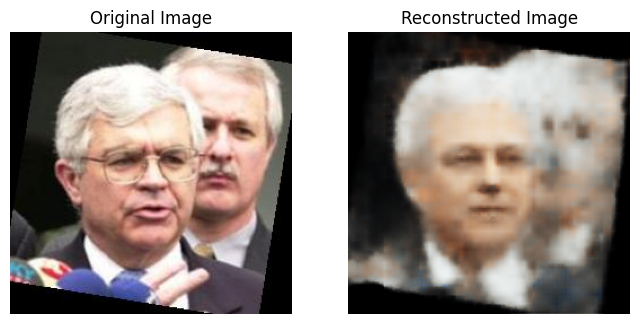

In [48]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicity


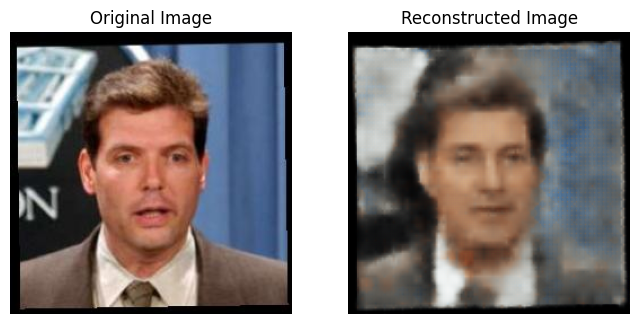

In [27]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicity


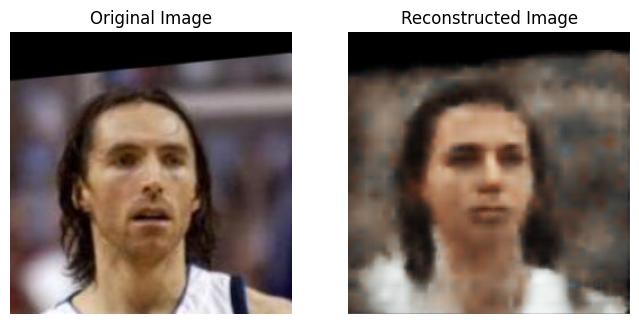

In [29]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicity


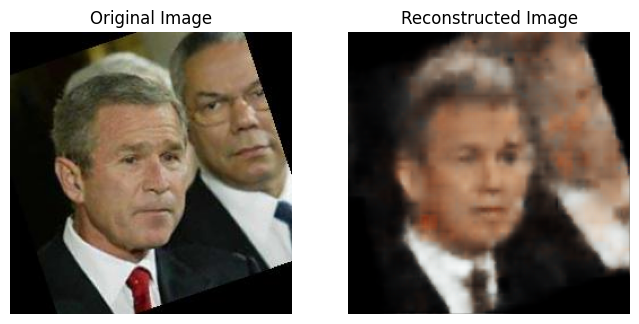

In [32]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicity


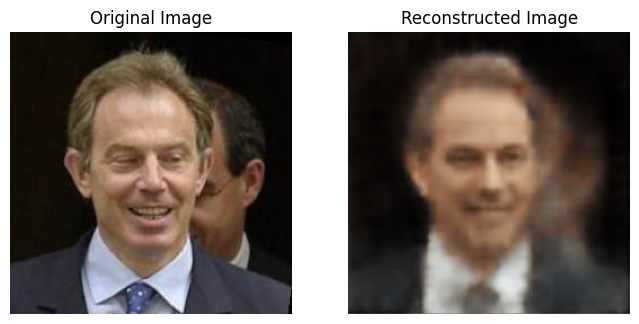

In [42]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicity